### IMPORTING LIBRARIES

In [16]:
#Import Needed Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict,GridSearchCV,StratifiedShuffleSplit
from sklearn.metrics import precision_score,recall_score,roc_auc_score,confusion_matrix,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [113]:
aug_train = pd.read_csv(r'C:\aug_train.csv',encoding = "ISO-8859-1")
aug_test = pd.read_csv(r'C:\aug_test.csv',encoding = "ISO-8859-1")
sample_submission = pd.read_csv(r'C:\Users\kkcha\Downloads\Krishna (roadmap +CP1)\sample_submission.csv',encoding = "ISO-8859-1")

In [127]:
aug_train[:5]

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [122]:
id=aug_test.enrollee_id.values
print('aug_train_Shape: ',aug_train.shape,'\n\n','aug_test_Shape: ',aug_test.shape,'\n\n','Sample_Submission_Shape: ',sample_submission.shape)

aug_train_Shape:  (19158, 14) 

 aug_test_Shape:  (2129, 13) 

 Sample_Submission_Shape:  (2129, 2)


In [115]:
#%% Initial Glance at Data
display(aug_train.info(verbose = True,null_counts=True))
print(aug_train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

None

(19158, 14)


#### aug_train has 19,158 observations with 13 features and 1 target variable. The dataset has missing data and must be handled properly.

In [118]:
aug_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

#### here are a good number of Missing values as can be seen above we have to devise ways to deal with them at

In [123]:
#Check for Duplicates in Train and Test Data
print('aug_train: ',aug_train.enrollee_id.duplicated().sum(),'Duplicates')
print('aug_test: ',aug_test.enrollee_id.duplicated().sum(),'Duplicates')

aug_train:  0 Duplicates
aug_test:  0 Duplicates


In [124]:
#Combine train and test data for analysis
y_train=aug_train.target
data=aug_train[aug_train.columns[:-1]].append(aug_test)
data.shape

(21287, 13)

In [125]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21287 entries, 0 to 2128
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             21287 non-null  int64  
 1   city                    21287 non-null  object 
 2   city_development_index  21287 non-null  float64
 3   gender                  16271 non-null  object 
 4   relevent_experience     21287 non-null  object 
 5   enrolled_university     20870 non-null  object 
 6   education_level         20775 non-null  object 
 7   major_discipline        18162 non-null  object 
 8   experience              21217 non-null  object 
 9   company_size            14727 non-null  object 
 10  company_type            14513 non-null  object 
 11  last_new_job            20824 non-null  object 
 12  training_hours          21287 non-null  int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 2.3+ MB


In [126]:
#Function To Calculate Number of Missing Datapoints for each rows
def missing(x,col):
    print('Missing Values in',col,': ',(x.shape[0]-x[col].notnull().sum()))

In [128]:
data.head(6)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8
5,21651,city_176,0.764,NaN,Has relevent experience,Part time course,Graduate,STEM,11,NaN,NaN,1,24


## Data Visualization and Feature Analysis

### enrollee_id
#### enrolle_id is an meaningless feature that is a unique value for each employee.

In [129]:
#%% count total number of unique values in enrollee_id column
print('Number of Unique Values: ' + str(aug_train['enrollee_id'].nunique()))

Number of Unique Values: 19158


In [130]:
print('Number of Unique Values: ' + str(aug_train['city'].nunique()))
print('Number of NaN Values: ' + str(sum(aug_train['city'].isnull())))
# top 10 cities 
print((aug_train['city'].value_counts()[0:10]))

Number of Unique Values: 123
Number of NaN Values: 0
city_103    4355
city_21     2702
city_16     1533
city_114    1336
city_160     845
city_136     586
city_67      431
city_75      305
city_102     304
city_104     301
Name: city, dtype: int64


#### city has 123 unique values and is a categorical variable.

Number of Missing Values:  0


count    19158.000000
mean         0.828848
std          0.123362
min          0.448000
25%          0.740000
50%          0.903000
75%          0.920000
max          0.949000
Name: city_development_index, dtype: float64

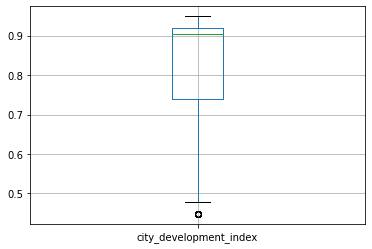

In [131]:
print("Number of Missing Values: ", aug_train['city_development_index'].isna().sum())
display(aug_train['city_development_index'].describe())
boxplot = aug_train.boxplot(column ='city_development_index')

### training_hours

Fig 1


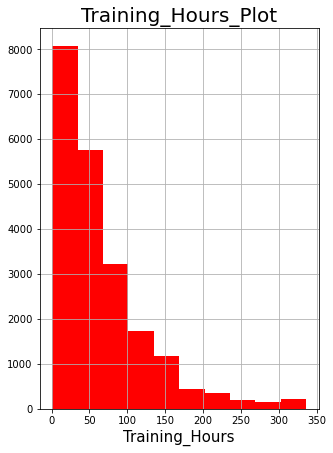

In [141]:
data.training_hours.describe()

#Plot of Training_Hours
print('Fig 1')
plt.figure(figsize=(5,7))
plt.title('Training_Hours_Plot',size=20)
plt.xlabel('Training_Hours',size=15)
plt.hist(data.training_hours,color='r')
plt.grid('True')
plt.show()

#### Majority of Candidates as can be seen from fig 1 spent less than 100 Hours on Training

### last_new_job

In [142]:
missing(data,'last_new_job')

Missing Values in last_new_job :  463


In [143]:
data.last_new_job.value_counts()


1        8924
>4       3643
2        3242
never    2710
3        1157
4        1148
Name: last_new_job, dtype: int64

Fig 2


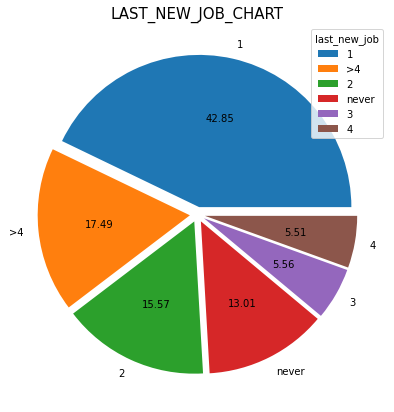

In [155]:
#Chart of New Jobs
print('Fig 2')
def piechart(col,x):
    " piechart(col,size);\n 'col' represents the column to be plotted it shld be entered as a string object; 'size' represents the desired figure size entered as a tuple example (5,10)"
    plt.figure(figsize=x)
    plt.title(col.upper()+'_CHART',size=15)
    plt.pie(x=data[col].value_counts().values,explode=[0.05 for x in range(len(data[col].value_counts().values))],autopct='%.2f',labels=data[col].value_counts().index)
    plt.legend(title=col,loc='best')
    plt.show()
piechart('last_new_job',(7,7))

#### Fig 2 Above is a plot of The distribution of the number of jobs previously held by candidates, Most Candidates have had just 1(One) previous job before applying to the company this represents 42% of the total candidates while candidates who have had more than 4 jobs represents 17% of the total candidates, some 13% of candidates have never had a previous job. It will be interesting to see if work experience influences candidates decision to accept an offer at the company

In [156]:
# Replace 'never' with 0, '>4' with 5 then fill missing with one
data.last_new_job.replace(['never','>4'],[0,5],inplace=True)
data.last_new_job.fillna('1',inplace=True)
data.last_new_job.astype('int64')
data.last_new_job.value_counts()

1    9387
5    3643
2    3242
0    2710
3    1157
4    1148
Name: last_new_job, dtype: int64

### company_type

Missing Values in company_type :  6774
Fig 3


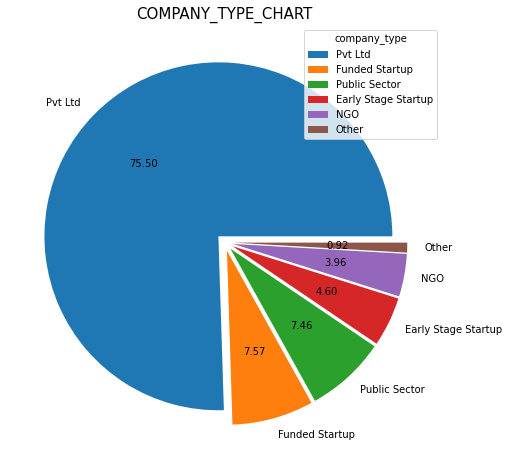

In [159]:
missing(data,'company_type')
#Pie Plot Of Company Type
print('Fig 3')
piechart('company_type',(8,8))

#### Fig 3 is a plot of Comapany type feature it has a low variance that implies that few classes occurs many time PVTLTD has 75% of the data points this can make it very uninformative and not useful to our target

In [160]:
#We will fill The missing values in company type with Pvt Ltd
data.company_type.fillna('Pvt Ltd',inplace=True)
data.company_type.replace(data.company_type.value_counts().index,[0,1,2,3,4,5],inplace=True)
data.company_type.value_counts()

0    17732
1     1098
2     1082
3      668
4      574
5      133
Name: company_type, dtype: int64

### company_size

Missing Values in company_size :  6560
Fig 4


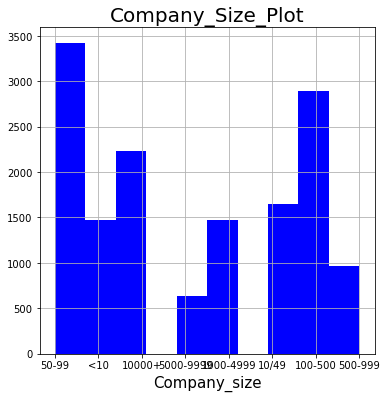

In [163]:
#missing values
missing(data,'company_size')
#Plot of Company_Size
print('Fig 4')
plt.figure(figsize=(6,6));
plt.title('Company_Size_Plot',size=20)
plt.xlabel('Company_size',size=15)
plt.grid('True')
plt.hist(data.company_size[data.company_size.notnull()],color='blue')
plt.show()

In [164]:
#Replacing Values in Company Size with custom encoding
data.company_size.replace(['<10','10/49','50-99','100-500','500-999','1000-4999','5000-9999','10000+'],[x for x in range(1,9)],inplace=True)
data.company_size.fillna(-1,inplace=True)
data.company_size.value_counts()

-1.0    6560
 3.0    3421
 4.0    2889
 8.0    2236
 2.0    1643
 6.0    1471
 1.0    1471
 5.0     965
 7.0     631
Name: company_size, dtype: int64

### missing_values in experience


In [171]:
#Missing values
missing(data,'experience')
# we will replace '<1' with 0 and '>20' with 21
#Missing values will be replaced mode which is '>20'
data.experience.fillna('>20',inplace=True)
data.experience.replace(['<1','>20'],[0,21],inplace=True)
data.experience=data.experience.astype('int64')

Missing Values in experience :  70


Fig 5


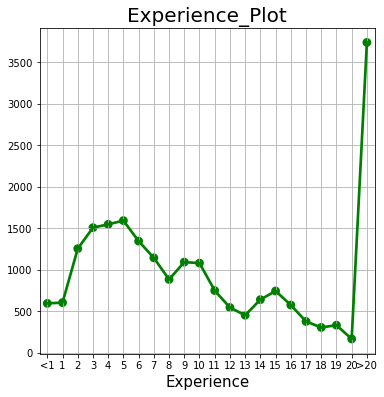

In [174]:
data.experience.value_counts().sort_index()
#Experience Plot
print('Fig 5')
plt.figure(figsize=(6,6))
plt.title('Experience_Plot',size=20)
sns.pointplot(x=[x for x in range(0,22)],y=data.experience.value_counts().sort_index().values,color='g')
plt.xticks([x for x in range(0,22)],['<1']+[str(x) for x in range(1,21)]+['>20'])
plt.xlabel('Experience',size=15)
plt.grid('True')
plt.show()

#### Candidates with 20+ years work experience accounts for much(3725 applicants) of the applicants. This group of candidates with much work experience can be said to be professionals. This can be seen from fig 4 plot above

### major_discpline 

In [175]:
missing(data,'major_discipline')
data.major_discipline.value_counts()

Missing Values in major_discipline :  3125


STEM               16113
Humanities           749
Other                421
Business Degree      364
Arts                 270
No Major             245
Name: major_discipline, dtype: int64

Fig 6


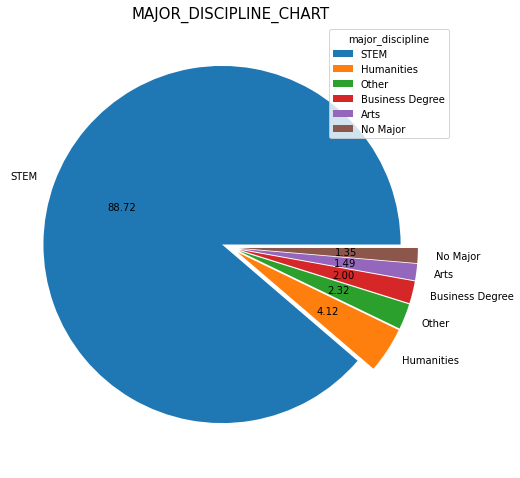

In [179]:
#Pie Plot
print('Fig 6')
piechart('major_discipline',(8,10))

#### Major_Discipline contains 3125 missing points. STEM accounts for 88% of the Disciplines.Therefore missing points will be replaced with STEM

In [180]:
data.major_discipline.fillna('STEM',inplace=True)
data.major_discipline.replace(['STEM','Humanities','Arts','Business Degree','No Major','Other'],[0,1,2,3,4,5],inplace=True)

### education_level

In [181]:
missing(data,'education_level')
data.education_level.value_counts()

Missing Values in education_level :  512


Graduate          12867
Masters            4857
High School        2239
Phd                 468
Primary School      344
Name: education_level, dtype: int64

In [182]:
#Fill Missing values in Education Level with Graduate
data.education_level.fillna('Graduate',inplace=True)
# custom Encoding Of Education Level
data.education_level.replace(['Primary School','High School','Graduate','Masters','Phd'],[0,1,2,3,4],inplace=True)

### enrolled_univesity

Missing Values in enrolled_university :  417
Fig 7


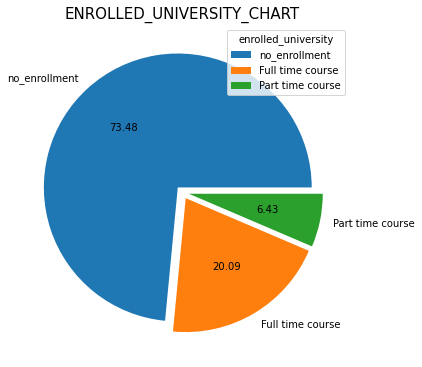

In [184]:
#Missing points
missing(data,'enrolled_university')
#Pie Chart
print('Fig 7')
piechart('enrolled_university',(6,8))

In [185]:
#Fill missing entries in enrolled data and  Custom encoding
data.enrolled_university.fillna('no_enrollment',inplace=True)
data.enrolled_university.replace(['no_enrollment','Part time course','Full time course'],[0,1,2],inplace=True)

### relevant_experience

In [186]:
missing(data,'relevent_experience')
#Custom Encoding
data.relevent_experience.replace(['Has relevent experience','No relevent experience'],[0,1],inplace=True)

Missing Values in relevent_experience :  0


In [188]:
data.relevent_experience.value_counts()


0    15316
1     5971
Name: relevent_experience, dtype: int64

In [190]:
data.head(6)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,8949,city_103,0.920,Male,0,0,2,0,21,-1.0,0,1,36
1,29725,city_40,0.776,Male,1,0,2,0,15,3.0,0,5,47
2,11561,city_21,0.624,NaN,1,2,2,0,5,-1.0,0,0,83
3,33241,city_115,0.789,NaN,1,0,2,3,0,-1.0,0,0,52
4,666,city_162,0.767,Male,0,0,3,0,21,3.0,1,4,8
5,21651,city_176,0.764,NaN,0,1,2,0,11,-1.0,0,1,24


### gender

In [191]:
missing(data,'gender')

Missing Values in gender :  5016


Fig 8


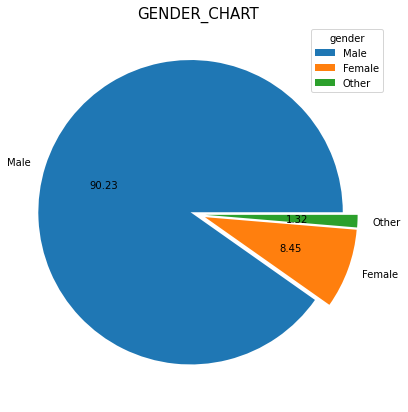

In [192]:
data.gender.value_counts()
#Pie Plot
print('Fig 8')
piechart('gender',(7,7))

#### Male Gender Make up for 90% of the candidates

In [193]:
#fill missing Gender points with Male
data.gender.fillna('Male',inplace=True)
data.gender.replace(['Female','Male','Other'],[0,1,2],inplace=True)


### city development index

Missing Values in city_development_index :  0
Fig 9


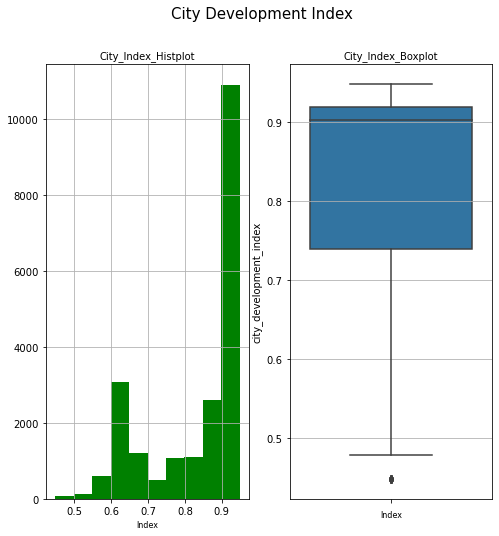

In [197]:
#Missning points
missing(data,'city_development_index')
#Plot of City Development Index
print('Fig 9')
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,8))
fig.suptitle('City Development Index',size=15)
ax1.set_title('City_Index_Histplot',size=10)
ax1.grid('True')
ax1.set_xlabel('Index',size=8)
ax1.hist(data.city_development_index,color='g')
ax2.set_title('City_Index_Boxplot',size=10)
ax2.grid('True')
ax2.set_xlabel('Index',size=8)
sns.boxplot(y=data.city_development_index,ax=ax2)
plt.show()

#### Fig 9 above shows that,city devwlopment index is constrained between the values of 0 and 1. The boxplot shows that there are outliers

### city

In [212]:
missing(data,'city')
data.city.value_counts()

Missing Values in city :  0


21      3021
16      1702
67       470
75       336
73       303
        ... 
3371       1
1322       1
7465       1
5416       1
0          1
Name: city, Length: 11006, dtype: int64

No Of Unique Cities:  11006
Fig 10


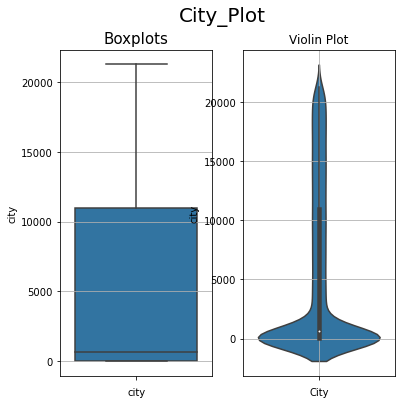

In [216]:
#Length Of Unique Values in City
print('No Of Unique Cities: ',len(data.city.unique()))

#City Plot
print('Fig 10')
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(6,6))
fig.suptitle('City_Plot',size=20)
ax1.set_title('Boxplots',size=15)
ax1.grid('True')
sns.boxplot(y=data.city,ax=ax1)
ax1.set_xlabel('city',size=10)
ax2.set_title('Violin Plot')
ax2.set_xlabel('City',size=10)
ax2.grid('True')
sns.violinplot(y=data.city,ax=ax2)
ax2.grid('True')
plt.show()

#### Fig 10 Is a plot of City Codes after extraction. The Boxplot on the right shows that There is a large range of values for city. It ranges from 0-20000 while it has a median of about 5000.Most of its values are within the range of 0-5000 as seen from the violin plot on the right side of fig 10.

In [217]:
#The Log of the values for City will be Taken to reduce and restrain to the range of other features
data.city=np.log10(data.city+1)
data.head(5)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,8949,0.000000,0.920,1,0,0,2,0,21,-1.0,0,1,36
1,29725,1.612784,0.776,1,1,0,2,0,15,3.0,0,5,47
2,11561,1.342423,0.624,1,1,2,2,0,5,-1.0,0,0,83
3,33241,0.602060,0.789,1,1,0,2,3,0,-1.0,0,0,52
4,666,0.698970,0.767,1,0,0,3,0,21,3.0,1,4,8


### target

In [219]:
aug_train.target.value_counts()

0.0    14381
1.0     4777
Name: target, dtype: int64

            Fig 11            


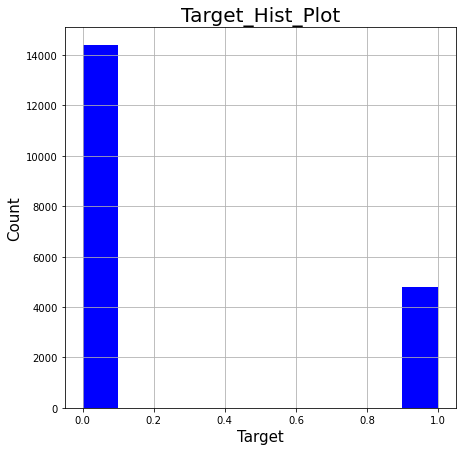

In [223]:
#Plot of Target
print('{:^30}'.format('Fig 11'))
plt.figure(figsize=(7,7))
plt.hist(y_train,color='b')
plt.xlabel('Target',size=15)
plt.ylabel('Count',size=15)
plt.title('Target_Hist_Plot',size=20)
plt.grid('True')
plt.show()

#### Fig 11 Above is a plot of Target values for the dataset if consists of values 0 and 1 in an imblanced ratio of 4:1 in favour of the 0 class. This can be very problematic to our model if not handled because it make it to be skewed to the 0 class amd may label most points as zero due to this effect.

In [224]:
data.head(5)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,8949,0.000000,0.920,1,0,0,2,0,21,-1.0,0,1,36
1,29725,1.612784,0.776,1,1,0,2,0,15,3.0,0,5,47
2,11561,1.342423,0.624,1,1,2,2,0,5,-1.0,0,0,83
3,33241,0.602060,0.789,1,1,0,2,3,0,-1.0,0,0,52
4,666,0.698970,0.767,1,0,0,3,0,21,3.0,1,4,8


In [225]:
#Split Data Back into test and Train
#Drop Id Column
data.drop('enrollee_id',axis=1,inplace=True)
aug_train=data.iloc[:aug_train.shape[0]]
aug_test=data.iloc[aug_test.shape[0]:]
aug_train['target']=y_train
print('aug_train_Shape: ',aug_train.shape,'\n\n','aug_test_Shape: ',aug_test.shape)

aug_train_Shape:  (19158, 13) 

 aug_test_Shape:  (19158, 12)


<ipython-input-225-fd37d8038c0c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aug_train['target']=y_train


In [227]:
aug_train.head(5)

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,0.000000,0.920,1,0,0,2,0,21,-1.0,0,1,36,1.0
1,1.612784,0.776,1,1,0,2,0,15,3.0,0,5,47,0.0
2,1.342423,0.624,1,1,2,2,0,5,-1.0,0,0,83,0.0
3,0.602060,0.789,1,1,0,2,3,0,-1.0,0,0,52,1.0
4,0.698970,0.767,1,0,0,3,0,21,3.0,1,4,8,0.0


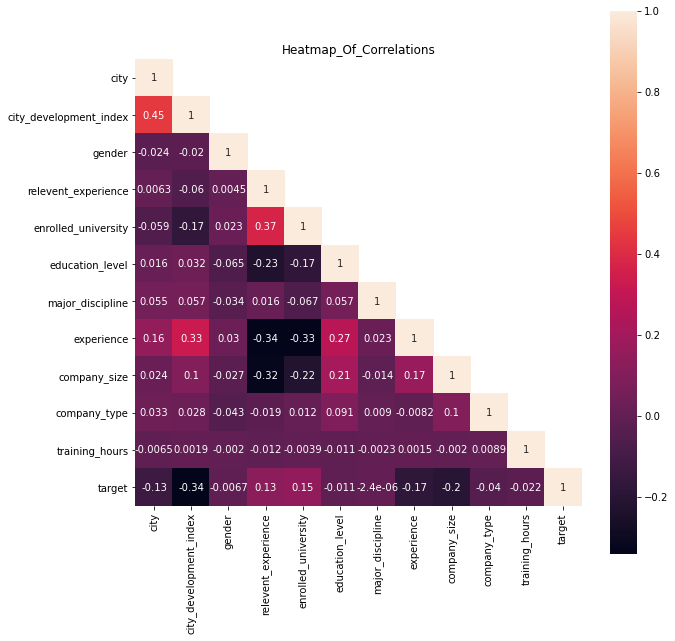

In [231]:
#HeatMap Of Correllations
plt.figure(figsize=(10,10))
corrmat=aug_train.corr()
mask=np.array(corrmat)
mask[np.tril_indices_from(corrmat)]=False
sns.heatmap(corrmat,mask=mask,vmax=1.0,square=True,annot=True)
plt.title('Heatmap_Of_Correlations')
plt.show()

In [232]:
#PCA
seed=42
pca=PCA(n_components=2,random_state=42)
pca.fit(aug_train.drop('target',axis=1))
z=pca.transform(aug_train.drop('target',axis=1))
pca.explained_variance_ratio_

array([0.98286426, 0.0129036 ])

#### From the explained variance ratio above of the Dimensionally reduced data. The first Principal component contains 98% of the information and sufficiently describes the whole data. This is and indication that the Features are linearly dependent and may have much colinearity among them.

In [233]:
#Clustering
kmeans=KMeans(n_clusters=2,random_state=42)
kmeans.fit(aug_train.drop('target',axis=1))
km=kmeans.transform(aug_train.drop('target',axis=1))
labels=kmeans.labels_
centers=kmeans.cluster_centers_

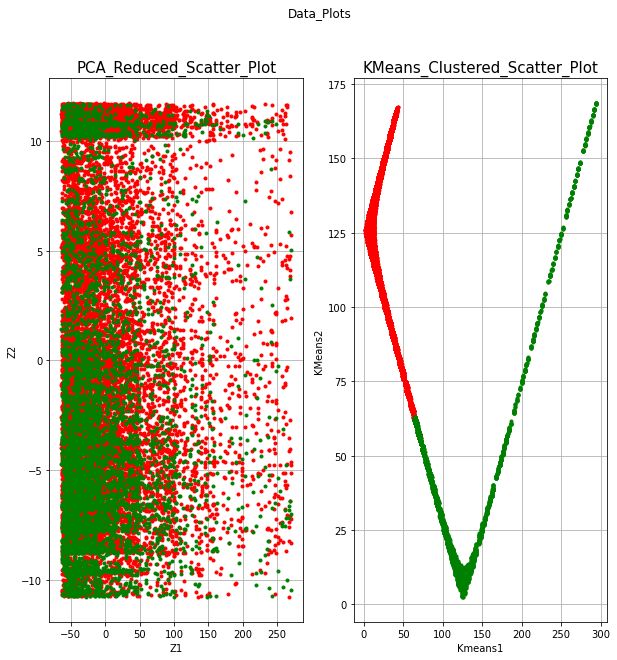

In [235]:
#Plot
z_data=pd.DataFrame({'z1':z[:,0],'z2':z[:,1],'target':y_train})
cluster_data=pd.DataFrame({'z1':km[:,0],'z2':km[:,1],'target':labels})
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,10))
fig.suptitle('Data_Plots')
ax1.set_title('PCA_Reduced_Scatter_Plot',size=15)
ax1.set_xlabel('Z1')
ax1.grid('True')
ax1.plot(z_data.z1[z_data.target==0],z_data.z2[z_data.target==0],'r.')
ax1.plot(z_data.z1[z_data.target==1],z_data.z2[z_data.target==1],'g.')
ax1.set_ylabel('Z2')
ax2.set_title('KMeans_Clustered_Scatter_Plot',size=15)
ax2.set_xlabel('Kmeans1');ax2.set_ylabel('KMeans2')
ax2.grid('True')
ax2.plot(cluster_data.z1[cluster_data.target==0],cluster_data.z2[cluster_data.target==0],'r.')
ax2.plot(cluster_data.z1[cluster_data.target==1],cluster_data.z2[cluster_data.target==1],'g.')
plt.show()

### MODEL BUILDING AND PREDICTION

#### We Will Use Roc_Auc as the metric for Optimization and Evaluation of our Models. We will also we predicting Probabilities instead of Actual Classes. We will also be Using Cross Validation To Prevent Overfitting

In [236]:
#STRATIFIED SHUFFLE SPLIT
split=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for x,y in split.split(aug_train,aug_train.target):
    x_train=aug_train.loc[x]
    val_test=aug_train.loc[y]
y_train=x_train.target.values
y_val=val_test.target.values
x_train.drop('target',axis=1,inplace=True)
val_test.drop('target',axis=1,inplace=True)
print("X_Train: ",x_train.shape," \n\n",'Validation_Test: ',val_test.shape)

X_Train:  (15326, 12)  

 Validation_Test:  (3832, 12)


In [237]:
#STANDARD SCALING
scaler=StandardScaler()
scaler.fit(data)
x_train_scaled=scaler.transform(x_train)
val_test_scaled=scaler.transform(val_test)
test_scaled=scaler.transform(aug_test)
print('aug_train_Scaled: ',x_train_scaled.shape,'\n\n','aug_test :',test_scaled.shape)

aug_train_Scaled:  (15326, 12) 

 aug_test : (19158, 12)


In [238]:
#Function For Evaluating Metrics
def score(model,x,y,Method):
    pred=cross_val_predict(model,x,y,cv=5)
    pred_proba=cross_val_predict(model,x,y,cv=5,method=Method)[:,1]
    print('Confusion_Matrix: ','\n\n',confusion_matrix(y,pred))
    print('Precision_Score: ',round(precision_score(y,pred),3),'\n\n','Recall_Score: ',round(recall_score(y,pred),3))
    print('Roc_Auc_Score: ',round(roc_auc_score(y,pred_proba),3))
    return pred,pred_proba

In [239]:
#ROC PLOT FUNCTION
def roc_plot(algorithm,y_true,y_pred_proba):
    fpr,tpr,thresholds=roc_curve(y_true,y_pred_proba)
    plt.figure(figsize=(10,10))
    plt.grid('True')
    plt.title(algorithm.capitalize()+' Roc Plot',size=20)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot(fpr,tpr,'r-',lw=2)
    plt.axis([0,1,0,1])
    plt.plot([0,1],[0,1],'g--')
    plt.show()

### logistic regression

In [240]:
log_clf=LogisticRegression(C=1,random_state=42)
log_pre,log_proba=score(log_clf,x_train_scaled,y_train,'predict_proba')

Confusion_Matrix:  

 [[10732   772]
 [ 2773  1049]]
Precision_Score:  0.576 

 Recall_Score:  0.274
Roc_Auc_Score:  0.751


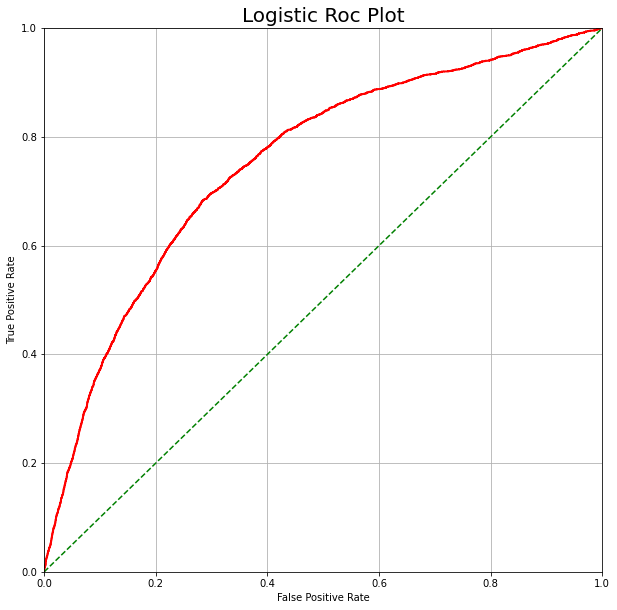

In [241]:
roc_plot('Logistic',y_train,log_proba)

In [242]:
#Test On Validation Data
log_pre,log_proba=score(log_clf,val_test_scaled,y_val,'predict_proba')

Confusion_Matrix:  

 [[2674  203]
 [ 672  283]]
Precision_Score:  0.582 

 Recall_Score:  0.296
Roc_Auc_Score:  0.767


#### Logistic Regression Gives An Roc_Score of 0.76 on Validation Data

### decision tree

In [245]:
#HyperParameter Tuning
tree_clf=DecisionTreeClassifier(random_state=42)
grid_params=[{'max_leaf_nodes':[10,20,35,50,100],'min_samples_split':[5,10,20,50],'min_samples_leaf':[5,10,20,30,35,50]}]
grid=GridSearchCV(tree_clf,grid_params,cv=5,scoring='roc_auc')
grid.fit(val_test,y_val)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid=[{'max_leaf_nodes': [10, 20, 35, 50, 100],
                          'min_samples_leaf': [5, 10, 20, 30, 35, 50],
                          'min_samples_split': [5, 10, 20, 50]}],
             scoring='roc_auc')

Best_Grid_Score:  0.8023286557528392 

 Best_Grid_Params:  {'max_leaf_nodes': 35, 'min_samples_leaf': 35, 'min_samples_split': 5}


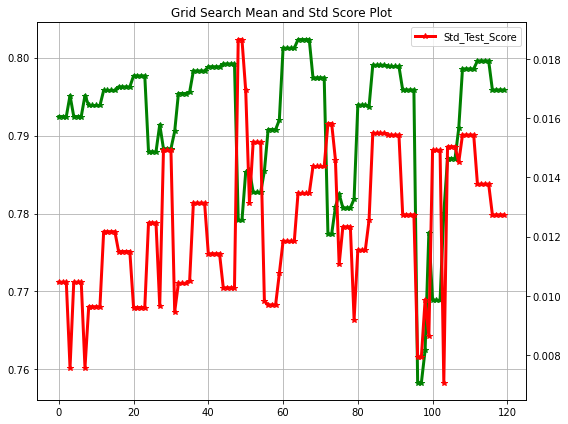

In [249]:
cv=grid.cv_results_
cv=pd.DataFrame(cv)
print('Best_Grid_Score: ',grid.best_score_,'\n\n','Best_Grid_Params: ',grid.best_params_)
#Plot Of Grid Results
fig,ax1=plt.subplots(figsize=(8,6))
ax1.grid('True')
plt.title('Grid Search Mean and Std Score Plot')
ax1.plot(cv.index,cv['mean_test_score'],'g*-',lw=3,label='Mean_Test_Score')
ax2=ax1.twinx()
ax2.plot(cv.index.values,cv['std_test_score'],'r*-',lw=3,label='Std_Test_Score')
plt.xlabel('Index_No')
fig.tight_layout()
plt.legend(loc='best')
plt.show()

#### The plot above represents The mean test score and Std test Score for Grid Search on decision Tree Classifier. The points represents The Mean test Csore While Std Test Score Represnts Std Test Score. Our Goal is to Get the best score values and the lowest Std test score. Between 80-90 we achieve our Best Test Score and a reasonably low Std Score.

In [250]:
tree_clf=DecisionTreeClassifier(random_state=42,max_leaf_nodes=50,min_samples_split=5,min_samples_leaf=35)
tree_clf.fit(x_train,y_train)

DecisionTreeClassifier(max_leaf_nodes=50, min_samples_leaf=35,
                       min_samples_split=5, random_state=42)

Confusion_Matrix:  

 [[9940 1564]
 [1704 2118]]
Precision_Score:  0.575 

 Recall_Score:  0.554
Roc_Auc_Score:  0.783


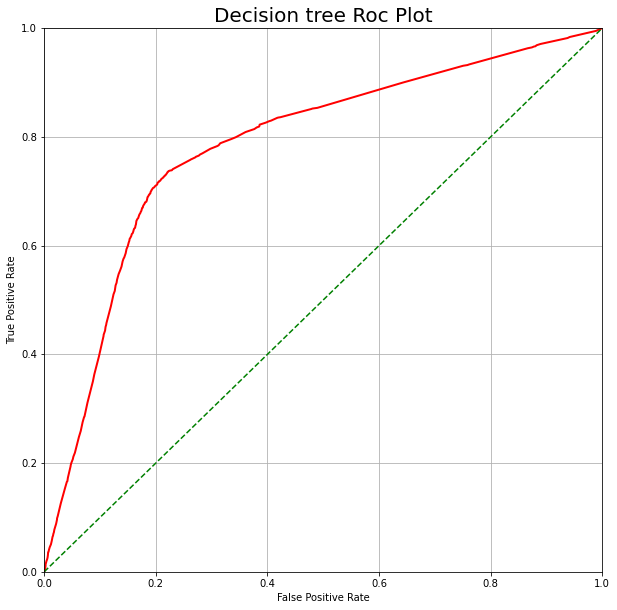

In [251]:
tree_pre,tree_proba=score(tree_clf,x_train,y_train,'predict_proba')
roc_plot('Decision Tree',y_train,tree_proba)

In [252]:
#Validation Test
score(tree_clf,val_test,y_val,'predict_proba')

Confusion_Matrix:  

 [[2549  328]
 [ 495  460]]
Precision_Score:  0.584 

 Recall_Score:  0.482
Roc_Auc_Score:  0.8


(array([0., 1., 0., ..., 0., 0., 0.]),
 array([0.0952381 , 0.66666667, 0.0952381 , ..., 0.19565217, 0.0877193 ,
        0.04054054]))

#### The Decision Tree Classifier Performs Relatively Better than Our Earlier Logistic Regression Algorithm with a score of 0.799

### GRADIENT BOOSTING CLASSIFIER

In [253]:
#Gradeint Boosting
grad_clf=GradientBoostingClassifier(random_state=42,max_leaf_nodes=50,min_samples_leaf=35,min_samples_split=5)
grad_clf.fit(x_train,y_train)

GradientBoostingClassifier(max_leaf_nodes=50, min_samples_leaf=35,
                           min_samples_split=5, random_state=42)

In [254]:
score(grad_clf,x_train,y_train,'predict_proba')

Confusion_Matrix:  

 [[10149  1355]
 [ 1915  1907]]
Precision_Score:  0.585 

 Recall_Score:  0.499
Roc_Auc_Score:  0.795


(array([1., 0., 0., ..., 0., 1., 0.]),
 array([0.52210964, 0.11427299, 0.08329486, ..., 0.0662988 , 0.5939745 ,
        0.46119906]))

In [255]:
#Gradient Boosting Classifier on Validation Test Data
score(grad_clf,val_test,y_val,'predict_proba')

Confusion_Matrix:  

 [[2577  300]
 [ 520  435]]
Precision_Score:  0.592 

 Recall_Score:  0.455
Roc_Auc_Score:  0.813


(array([0., 0., 0., ..., 0., 0., 0.]),
 array([0.08593021, 0.46424794, 0.06826949, ..., 0.11350118, 0.04554213,
        0.06547844]))

#### Gradient Boosting Classifier Acheives an Roc_Auc_Score of 0.812 on Validation Test

### GAINING INSIGHTS INTO WHY CANDIDATES DECIDES TO STAY OR LEAVE THE COMPANY USING THE MODELS

In [256]:
x_train.head(5)

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
17855,1.342423,0.624,1,0,0,2,0,10,3.0,0,1,90
17664,4.247114,0.920,1,1,0,0,0,5,-1.0,0,0,15
13404,1.707570,0.896,1,0,0,2,0,12,6.0,4,5,36
13366,4.126034,0.920,1,0,0,2,0,5,4.0,1,1,53
15670,1.832509,0.855,0,0,2,2,0,5,-1.0,0,1,158


In [257]:
#Gradient Boosting Feature Importances
z_grad=pd.DataFrame()
z_grad['Features']=data.columns.values
z_grad['Importance_Rank']=grad_clf.feature_importances_
z_grad=z_grad.sort_values(by='Importance_Rank',ascending=False)
z_grad

,Features,Importance_Rank
1,city_development_index,0.572025
8,company_size,0.270903
5,education_level,0.056385
7,experience,0.023558
10,last_new_job,0.018239
0,city,0.017495
11,training_hours,0.015234
4,enrolled_university,0.011461
3,relevent_experience,0.009759
9,company_type,0.001786


#### The Most Important Features Used in Gradient Boosting Regressor are City_Devlopment_Index,Company Size,Education Level,Experience and Last New in descending oreder of less importance

In [258]:
#Decision Tree Feature Importances
z_tree=pd.DataFrame()
z_tree['Features']=data.columns
z_tree['Importance_Rank']=tree_clf.feature_importances_
z_tree=z_tree.sort_values(by='Importance_Rank',ascending=False)
z_tree

,Features,Importance_Rank
1,city_development_index,0.563899
8,company_size,0.248435
5,education_level,0.068567
0,city,0.032348
3,relevent_experience,0.023383
7,experience,0.022073
10,last_new_job,0.017504
11,training_hours,0.011326
4,enrolled_university,0.008710
6,major_discipline,0.001933


#### For Decision Tree Classifier The Most Importance Geatures for Differntiating Between Candidates who left after Training and those who remained Where City_Development_Index,Company_Size,Education Level,City,Relevant Experience and Experience

#### We will Use RFE Wrapper to Get a Clue of The most Important Features For Logistic Regressiin

In [259]:
from sklearn.feature_selection import RFE

In [260]:
rfe=RFE(log_clf,n_features_to_select=4)
rfe.fit(x_train,y_train)
rfe.ranking_
z_log=pd.DataFrame()
z_log['Features']=data.columns
z_log['Importance_Rank']=rfe.ranking_
z_log.index.name='Index'
z_log=z_log.sort_values(ascending=True,by='Importance_Rank')
z_log

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Features,Importance_Rank
Index,,
1,city_development_index,1
3,relevent_experience,1
4,enrolled_university,1
5,education_level,1
8,company_size,2
2,gender,3
9,company_type,4
6,major_discipline,5
10,last_new_job,6


#### For Our Logistic Regression Classifier The most Importance Features for Decision Making where City_Development_Index,Education Level,Experience, Company Size

Fig 12


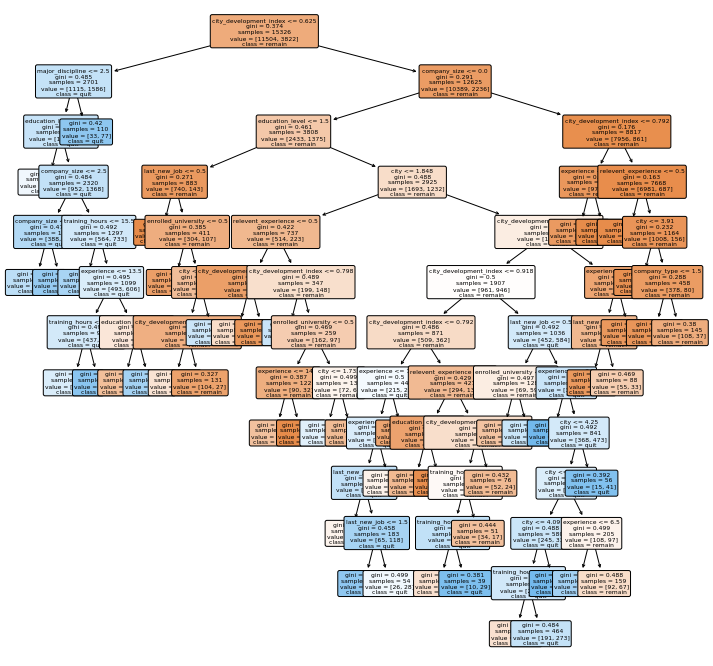

In [264]:
print('Fig 12')
plt.figure(figsize=(12,12))
plot_tree(tree_clf,feature_names=data.columns.values,fontsize=6,rounded=True,class_names=['remain','quit'],filled=True)
plt.show()

#### So What Can We Say About Our Features?.


#### The Singular Most Important Feature For Decision Making according to our Models Was City Development Index. The Tree Plot on Fig 3.0 Shows us that Candidates with city development index less than 0.625 where more likely to remain more than those with city development index. Which Means the decisuon by Candidates to Remain in the company was inversely Proportional to the City Development index.
#### Other Features Necessary for Predicting The probabilities of Candidates to Stay Back at The Company or to seek Jobs else where were Education Level Experience or Company Size.

#### 3.3. Candidates who did not indicate the size of their previous workplace where likely to to remain

#### A closer study of Fig Will Give Relationship Among These Important Features